---

## Innovation Process and Probabilistic Triggering Function

We assume a state-space model where the innovation $(z_k)$ is defined for time instant $k$ as

$z_k = x_k - \hat{x}_{k|k-1}$

where:
- $x_k$ is the true state  
- $\hat{x}_{k|k-1}$ is the predicted state estimate  

The innovation $z_k$ is assumed to be a Gaussian random variable with variance $\sigma_{z_k}^2$ that can be determined within the Kalman update step. $z_k^*$ is a unit variance "normalized" random variable $z_k^*=z_k/\sigma_{z_k}$.

The system transmits updates based on a probabilistic trigger function $\phi_\beta(z_k^*, \alpha)$, depending on the "normalized" innovation $z_k^*=z_k/\sigma_{z_k}$ random variable $\mathcal{N}(0,1)$ and a scaling factor $\alpha$ that allows to control the likelihood of a triggering event $\gamma_k$. Having $z_k^*$ allows to model any temporal variable variance at time instant $k$, i.e., and the normalized probabilistic trigger functions is

$\phi_\beta(z_k^*, \alpha) = \exp\left( -\frac{1}{2} \left( \frac{z_k^*}{\sqrt{\alpha}} \right)^\beta \right)$.

---

In [ ]:
%pip install scipy
%pip install matplotlib

In [2]:
import numpy as np

def phi_beta(z_k, alpha, beta):
    return np.exp(-0.5 * (np.abs(z_k) / (np.sqrt(alpha)) )**beta )

---

## Event-Triggering Mechanism and (Event) Rate

The decision to trigger an event is based on a uniformly distributed random variable $U_k \sim \mathcal{U}(0, 1)$, which is compared against the trigger function

$\gamma_k =
\begin{cases}
1 & \text{if } U_k > \phi_\beta(z_k^*, \alpha), \\
0 & \text{if } U_k \leq \phi_\beta(z_k^*, \alpha).
\end{cases}$

Here:
- $\gamma_k = 1$ indicates that an update is transmitted  
- $\gamma_k = 0$ indicates that no update is transmitted

With this, a event rate $\mathbf{E}[\gamma_k]$ can be determined. Hereby, the probability of triggering an event is

$P(\gamma_k=1)=1-\phi_\beta(z_k^*,\alpha)$,

and the average event rate can be obtained by integrating the probability $P(\gamma_k)$ over the distribution of $z_k^*$. Because $z_k^*$ is a realization from $Z^*\sim \mathcal{N}(0,1)$, we can rewrite,

$\mathbf{E}[\gamma_k] = 1 - \mathbf{E}[\phi_\beta(Z^*,\alpha)]$,

or with $\varphi(z^*)$ being the standard normal pdf of $z^*$

$\mathbf{E}[\gamma_k] = 1 - \int_{-\infty}^{\infty} \phi_\beta(z^*,\alpha)\varphi(z^*)dz^*$.

---

In [3]:
from scipy.integrate import quad
from scipy.stats import norm

def event_rate(alpha, beta):
    integrand = lambda z_star: phi_beta(z_star, alpha, beta) * norm.pdf(z_star)
    return 1 - quad(integrand, -np.inf, np.inf)[0]

---

## Posterior MSE (Distortion)

The posterior MSE represents the mean squared error between the true innovation $z_k$ and the updated estimate after transmission. For $\gamma_k=1$, a full update of $z_k$ is transmitted and the RX state-space estimate is perfectly in sync with transmitted state-space, i.e., the posterior variance as the mean squared error between true and updated estimate is zero. If $\gamma_k=0$, the state estimate of the RX remains unchanged, and the error (distortion) is equal to the prio variance $\sigma_{z_k}^2$. Thus, the posterior MSE is:

$\text{MSE} = \sigma_{z_k}^2 P(\gamma_k=0)$

and since $P(\gamma_k=0)=\mathbf{E}[\phi_\beta(Z^*,\alpha)]$ the 

$\text{MSE} = \sigma_{z_k}^2 \int_{-\infty}^{\infty} \phi_\beta(z^*,\alpha) p_{Z^*}(z^*) dz^* = \sigma_{z_k}^2 \int_{-\infty}^{\infty} \phi_\beta(z^*,\alpha) \varphi(z^*) dz^* $

# Question?
Can I assume steady state KF here? so, $\sigma_{z_k} \rightarrow \sigma_z$?

---

In [4]:
def posterior_mse(alpha, beta, sigma_z2):
    return sigma_z2 * (1 - event_rate(alpha, beta))

In [5]:
# Simulation parameters
sigma_z2 = 1.0     # normalized variance of innovation

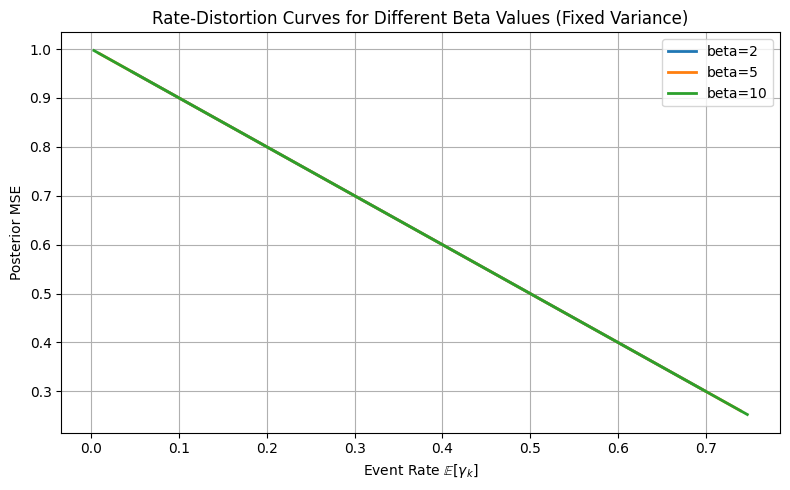

In [6]:
import matplotlib.pyplot as plt

alphas = np.linspace(1e-1, 1e1, 1000)
beta_values = [2,5,10]  # List of beta values to sweep over

plt.figure(figsize=(8, 5))

for beta in beta_values:
    rates = [event_rate(alpha, beta) for alpha in alphas]
    #mse_vals = [posterior_mse(alpha, beta, sigma_z2) for alpha in alphas]
    mse_vals = [sigma_z2 * (1-rate) for rate in rates]  # Since MSE is proportional to (1 - event_rate)
    plt.plot(rates, mse_vals, label=f'beta={beta}', lw=2)

plt.xlabel(r'Event Rate $\mathbb{E}[\gamma_k]$')
plt.ylabel('Posterior MSE')
plt.title(
    f'Rate-Distortion Curves for Different Beta Values (Fixed Variance)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

---

# Random Ideas

- Is this water-filling with time-varying channel gains?
- Is this power-adaptive source coding?
- Is this a fading channel rate-distortion problem?
- Isn't this a Bernoulli Erasure Encoder?
- Aren't we randomly erase Gaussian samples?
- The optimal Gaussian Rate-Distortion is $D_{opt}(R)=\sigma_z^2 2^{-2R}$ where we have $D_k=\sigma_{z_k}^2 (1 - \mathbf{E}[\gamma_k])$.
- Binary source + Erasures: $X \in {0,1}$, $X\sim Bern(1/2)$, but $\hat{X} \in {0,1,e}$ with distortion measure $0$ for correct and $1$ for wrong/erased, $D=1-R$ or $R(D)=1-D$.
- Gaussian Source + Erasures: $Z\sim \mathcal{N}(0,\sigma)$ then, "sending" perfectly means distortion $D(.)=0$ or nothing is sent $D(.)=\sigma^2$. Then if transmission probability/rate is $R$, we get $D=\sigma^2(1-R)$
- Again optimal Gaussian source coding follows: $R(D)=1/2 \log2(\frac{\sigma^2}{D})$, i.e., exponential decay in distortion, not linear decay as in $R(D)=1-\frac{D}{\sigma^2}$

# Wyner-Ziv?
For source $X$ and a correlated side information $Y$ at the decoder, that the encoder does not know, $X=Y+Z$, with $Z\sim \mathcal{N}(0,\sigma_Z^2)$ and distortion measurement $D$ evaluating the MSE, the rate-distortion function is:

$R_{WZ}(D)=\frac{1}{2}\log(\frac{\sigma_Z^2}{D})$

The important aspect with Wyner-Ziv is that there is no rate loss in not knowing $Y$ at the encoder. The connection I saw/see is:

- True state: $x_k$
- Encoder estimate: $\hat{x}_k^{Tx}$
- Decoder estimate: $\hat{x}_k^{Rx}$
- Innovation: $z_k = x_k - \hat{x}_k^{Rx}$
- Wyner-Ziv: $X = Y + Z$, where $Y=\hat{x}_k^{Rx}$ and $Z = z_k$
- The decoder has the side information $Y$ and the encoder only sends information about its innovation
- Wyner-Ziv typically achieves optimal rate/distortion metrics
- From literature we know that "zero delay Wyner-Ziv" looses all its nice properties: "The Zero-Delay Wyner-Ziv Problem" by Yonatan Kaspi and Neri Merhav (the lookahead issue they discuss, is somewhat interesting)
- Also, trigger based communication is time-sharing between, as described as optimal coding concept in "The Zero-Delay Wyner-Ziv Problem", BUT between to "maximum" fix points $(0,\sigma_z^2)$ and $(1,0)$ that is not optimal
- BUT, maybe you can get from this result WHY delay/latency is extremely costly!
- ... for coding gains we always require large block-length :-(
- Probably, https://arxiv.org/pdf/1411.7632 fits better "Semidefinite Programming Approach to Gaussian Sequential Rate-Distortion Trade-offs"

---

---

# Some Known Bounds from literature

---

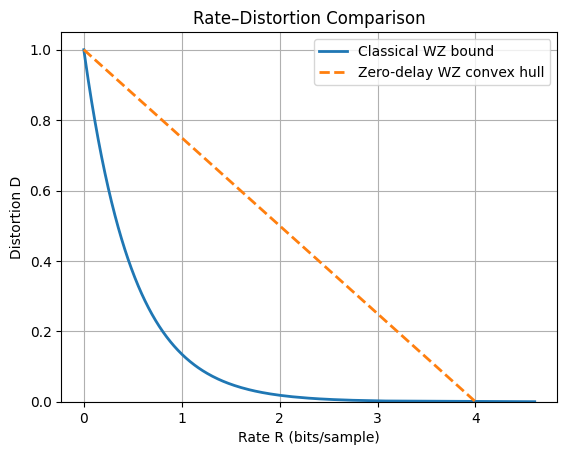

In [9]:
from scipy.spatial import ConvexHull

# --------------------------------
# Classical Gaussian WZ bound
# R(D) = 0.5 log(sigma_z^2 / D)
# --------------------------------
D_classical = np.linspace(1e-4, sigma_z2, 500)
R_classical = 0.5 * np.log(sigma_z2 / D_classical)

# Zero-delay WZ convex hull
# For zero-delay scalar encoders:
# achievable region = convex hull of scalar points
R_full = 4.0  # arbitrary high-rate endpoint
lambda_vals = np.linspace(0, 1, 200)

R_zero_delay = lambda_vals * R_full
D_zero_delay = (1 - lambda_vals) * sigma_z2
    
plt.plot(R_classical, D_classical,
         label="Classical WZ bound",
         linewidth=2)

plt.plot(R_zero_delay, D_zero_delay,
         linestyle="--",
         linewidth=2,
         label="Zero-delay WZ convex hull")

plt.xlabel("Rate R (bits/sample)")
plt.ylabel("Distortion D")
plt.title("Rate–Distortion Comparison")
plt.legend()
plt.grid(True)
plt.ylim(0, sigma_z2 * 1.05)

plt.show()